In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm

# 1. Imports and Helper Functions
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.shape)
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        shape = y.size()
        _, ind = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y_hard = y_hard.view(*shape)
        return (y_hard - y).detach() + y
    return y

# 2. Build Model
class VAE(nn.Module):
    def __init__(self, K=10, N=30):
        super(VAE, self).__init__()
        self.K = K
        self.N = N
        
        # Encoder
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, K*N)
        
        # Decoder
        self.fc4 = nn.Linear(N*K, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
    
    def forward(self, x, tau=1):
        # Encoder
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        logits = self.fc3(h)
        
        # Gumbel-Softmax
        logits_y = logits.view(-1, self.K)
        y = gumbel_softmax(logits_y, tau).view(-1, self.N, self.K)
        
        # Decoder
        y_flat = y.view(y.size(0), -1)
        h = F.relu(self.fc4(y_flat))
        h = F.relu(self.fc5(h))
        logits_x = self.fc6(h)
        
        return logits_x, logits_y

# Loss function
def vae_loss(recon_x, x, q_y_logits):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum') / x.size(0)

    q_y = F.softmax(q_y_logits, dim=-1)
    log_q_y = F.log_softmax(q_y_logits, dim=-1)
    KL = torch.sum(q_y * (log_q_y - torch.log(torch.tensor(1.0 / 10))), dim=-1).mean()
    
    return BCE + KL, BCE, KL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Train
batch_size = 100
transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

tau0 = 1.0
anneal_rate = 0.00003
min_temp = 0.5
num_epochs = int(50000 / len(train_loader)) + 1

progress_bar = tqdm(range(num_epochs * len(train_loader)))
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()
        recon_x, q_y_logits = model(data)

        loss, bce_loss, kl_loss = vae_loss(recon_x, data, q_y_logits)
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f} BCE: {bce_loss.item():.4f} KL: {kl_loss.item():.4f}')
        progress_bar.update(1)
        # Temperature Annealing
        tau = max(tau0 * np.exp(-anneal_rate * (batch_idx + epoch*len(train_loader))), min_temp)
        
        if (batch_idx + epoch*len(train_loader)) % 5000 == 0:
            print('Batch %d, Loss: %.4f' % (batch_idx + epoch*len(train_loader), loss.item()))


  0%|          | 0/50400 [00:00<?, ?it/s]

Exported graph: graph(%onnx::Gemm_0 : Float(100, 784, strides=[784, 1], requires_grad=0, device=cpu),
      %temperature : Long(requires_grad=0, device=cpu),
      %fc1.weight : Float(512, 784, strides=[784, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(512, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(256, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %fc3.weight : Float(300, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc3.bias : Float(300, strides=[1], requires_grad=1, device=cpu),
      %fc4.weight : Float(256, 300, strides=[300, 1], requires_grad=1, device=cpu),
      %fc4.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %fc5.weight : Float(512, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc5.bias : Float(512, strides=[1], requires_grad=1, device=cpu),
      %fc6.weight : Float(784, 512, strides=[512, 1], requires

KeyboardInterrupt: 

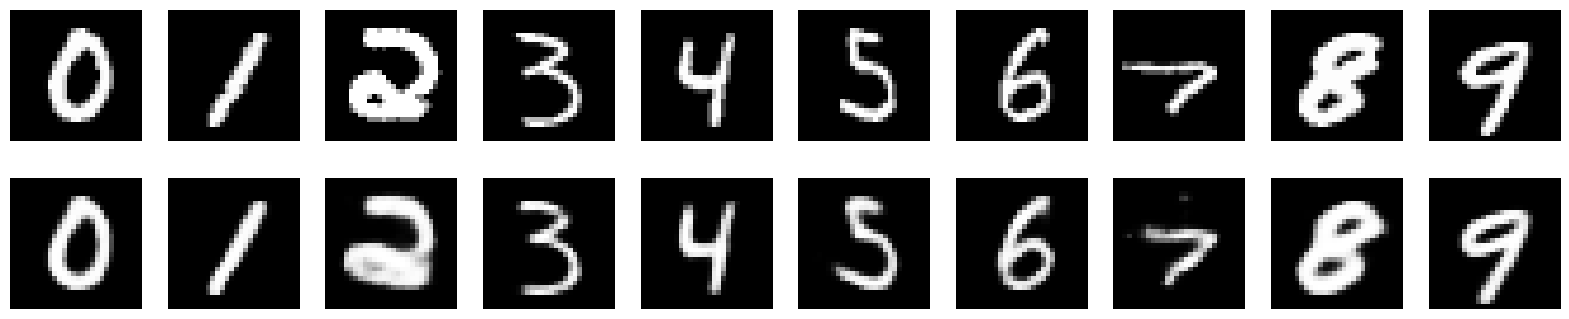

In [2]:
import matplotlib.pyplot as plt

# Sample and reconstruct images from the trained model
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=True)

sample_images = [None] * 10  # A list to hold one sample for each class
found_classes = set()

for data, labels in test_loader:
    data, labels = data.to(device), labels.to(device)
    
    for i in range(10):  # since there are 10 classes
        if i not in found_classes:
            # Check if this class exists in the current batch
            indices = (labels == i).nonzero(as_tuple=True)[0]
            if len(indices) != 0:
                sample_images[i] = data[indices[0]]  # add the first occurrence
                found_classes.add(i)
                
    if len(found_classes) == 10:  # stop when all classes are found
        break

# Flatten each image and stack them
input_batch = torch.stack([img.view(784) for img in sample_images])

# Reconstruct the images
reconstructed_logits, _ = model(input_batch)
reconstructed_images = torch.sigmoid(reconstructed_logits)  # Convert logits to images

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0][i].imshow(sample_images[i][0].cpu().detach().numpy(), cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(reconstructed_images[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
    axes[1][i].axis('off')

plt.show()


/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


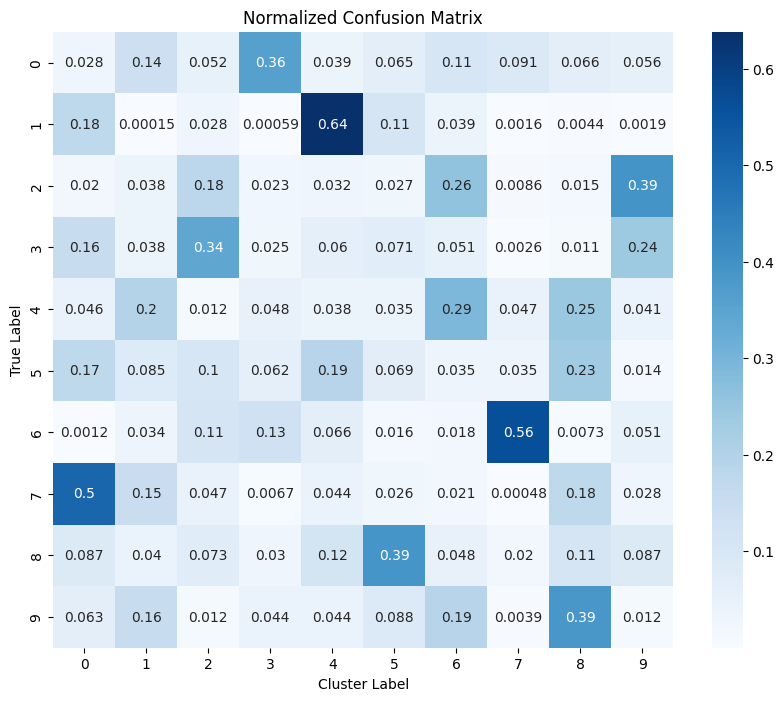

The clustering accuracy is:  0.41325
The adjusted rand index is:  0.17388998190744082


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns  # 这个库可以帮助我们更好地绘制混淆矩阵
from sklearn.metrics import adjusted_rand_score

def cluster_latents_with_kmeans(model, dataloader, device="cuda"):
    model.eval()
    
    all_latents = []
    true_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to(device)
            batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            _, logits_y = model(batch_data) # 注意这里我们获取了logits_y
            # 为了得到每个图像的一个K维表示，我们计算logits_y中每N个输出的平均值
            averaged_logits = logits_y.view(-1, 30, 10).mean(dim=1)
            all_latents.append(averaged_logits)
            true_labels.extend(batch_labels)
    
    all_latents = torch.cat(all_latents, dim=0)
    kmeans = KMeans(n_clusters=10).fit(all_latents.cpu())
    
    cluster_assignments = kmeans.predict(all_latents.cpu())
    
    return cluster_assignments, np.array(true_labels)



def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap=cmap, 
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Cluster Label')
    plt.show()

# 使用以上函数
train_loader_for_clustering = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=10000, shuffle=True)  # 使用较大的batch_size来获取更多数据

cluster_assignments, true_labels = cluster_latents_with_kmeans(model, train_loader_for_clustering, device=device)

# 由于KMeans的聚类不会按照真实的标签来聚类，所以我们可能需要对混淆矩阵进行处理以找到最佳匹配，但这是一个进阶步骤。以下代码仅显示基础混淆矩阵。
plot_confusion_matrix(true_labels, cluster_assignments, classes=list(range(10)))

# Calculate the accuracy of the clustering
def calculate_clustering_accuracy(cluster_assignments, true_labels):
    # 计算每个聚类的最常见的真实标签
    labels_most_common_in_cluster = []
    for cluster in range(10):
        most_common_in_cluster = \
            np.bincount(true_labels[cluster_assignments==cluster]).argmax()
        labels_most_common_in_cluster.append(most_common_in_cluster)
    
    # 计算每个聚类的准确率
    pred_labels = [labels_most_common_in_cluster[cluster] for cluster in cluster_assignments]
    pred_labels = np.array(pred_labels)
    acc = np.sum(pred_labels == true_labels) / len(true_labels)
    
    return acc

acc = calculate_clustering_accuracy(cluster_assignments, true_labels)
print("The clustering accuracy is: ", acc)

rand_index = adjusted_rand_score(true_labels, cluster_assignments)
print("The adjusted rand index is: ", rand_index)
